***В этом примере используются дополнительные модули для вывода моделей и визуализации процесса обучения. Установите их, если они отсутствуют в вашей среде***

In [ ]:
!pip install tqdm
!pip install matplotlib 
!pip install pytorch_msssim

## Данный пример демонстрирует возможности CNN с архитектурой кодировщик-декодировщик к аппроксимации сложных данных с медиа-контентом и периодической компонентой

#### В качестве исходных данных использовался gif-файл с персонажем манги Menhera. Gif-файл содержит 10 кадров (3-канальные RGB-изображения). Разрешение изображений было уменьшено до 45x45 пикселей.

![SegmentLocal](tools/media/anime_10f_fullsize.gif "segment")

#### Функция для подготовки датасета из gif-файла в вид numpy матриц  

In [1]:
import numpy as np
from PIL import Image, ImageSequence

def get_anime_timeseries(rgb=True):
    with Image.open('tools/media/anime_10f.gif') as im:
        array = []
        for frame in ImageSequence.Iterator(im):
            if rgb:
                im_data = frame.copy().convert('RGB').getdata()
                im_array = np.array(im_data).reshape(frame.size[1], frame.size[0], 3)
            else:
                im_data = frame.copy().convert('L').getdata()
                im_array = np.array(im_data).reshape(frame.size[1], frame.size[0], 1)
            array.append(im_array)
        array = np.array(array)        
        array = array/255
    return array


def get_cycled_data(cycles_num, is_rgb):
    array = get_anime_timeseries(rgb=is_rgb)
    arr = []
    for i in range(cycles_num):
        arr.append(array)
    arr = np.array(arr)
    arr = arr.reshape(arr.shape[0]*arr.shape[1], arr.shape[2], arr.shape[3], arr.shape[4])
    return arr

### Инициализация обучающей и тестовой выборок

Train shape: (50, 45, 45)
Test shape: (10, 45, 45)


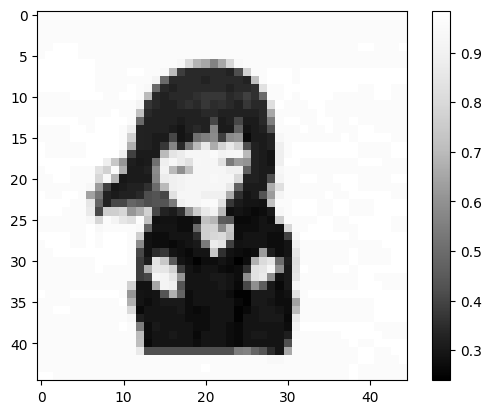

In [2]:
import matplotlib.pyplot as plt

train = get_cycled_data(5, is_rgb=False)[:, :, :, 0]
print(f'Train shape: {train.shape}')
test = get_cycled_data(1, is_rgb=False)[:, :, :, 0]
print(f'Test shape: {test.shape}')


plt.imshow(train[3], cmap='Greys_r')
plt.colorbar()
plt.show()

### Подготовка датасетов с помощью реализованных методов в зависимости от предыстории и горизонта прогноза

Постановка задачи состоит в предсказании 10 следующих кадров на основе 20 предыдущих

In [3]:
from torchcnnbuilder.preprocess import multi_output_tensor, single_output_tensor

train_dataset = multi_output_tensor(data=train,
                                    pre_history_len=20,
                                    forecast_len=10)
test_dataset = single_output_tensor(data=test, 
                                   forecast_len=10)

### Инициализация простой модели (с 5 слоями сверток и 5 слоями транспонированных сверток) - 20 кадров в качестве предыстории, 10 кадров в качестве горизонта прогноза.

In [4]:
from torch import nn
from torchcnnbuilder.models import ForecasterBase

model = ForecasterBase(input_size=[45, 45],
                       in_time_points=20,
                       out_time_points=10,
                       n_layers=5,
                       finish_activation_function=nn.ReLU(inplace=True))
device='cuda'
model=model.to(device)

### Инициализация набора параметров для обучения

In [5]:
from torch import optim
from torch.utils.data import DataLoader

epochs = 100000
batch_size = 500

dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.L1Loss()
losses = []
epochs_list = []

### Обучение моодели с сохранением промежуточных состояний

In [10]:
from tqdm.notebook import tqdm
import time
import os

# создание папки для сохранения промежуточных изображений
root = os.path.abspath("")
opt_hist_path = f'{root}/anime_opt_hist_images'
if not os.path.exists(opt_hist_path):
    os.makedirs(opt_hist_path)

start = time.time()
for epoch in tqdm(range(epochs)):
    loss = 0
    
    for train_features, test_features in dataloader:
        train_features = train_features.to(device)
        test_features = test_features.to(device)
        
        optimizer.zero_grad()
        outputs = model(train_features)    
        train_loss = criterion(outputs, test_features)        
        train_loss.backward()
        optimizer.step()        
        loss += train_loss.item()
    
    loss = loss / len(dataloader)    
    losses.append(loss)
    epochs_list.append(epoch)
    
    # здесь мы сохраняем историю оптимизации в виде прогнозируемых изображений для визуализации процесса сходимости
    if epoch % 10000 == 0 or epoch == 5 or epoch==50 or epoch==300 or epoch == 1000 or epoch == 5000:
        for X, y in dataloader:
            X = X.to(device)
            prediction = model(X)
            prediction = prediction.detach().cpu().numpy()[0]
            real = y.numpy()[0]
    
            fig, (axs) = plt.subplots(2, 10, figsize=(10, 3))
            for i in range(10):
                axs[1, i].imshow(prediction[i], cmap='Greys_r', vmax=1, vmin=0)
                axs[1, i].set_title(F'Frame {i}')
                axs[0, i].imshow(real[i], cmap='Greys_r', vmax=1, vmin=0)
                axs[0, i].set_title(F'Frame {i}')
                axs[0, i].set_xticks([])
                axs[1, i].set_xticks([])
                axs[0, i].set_yticks([])
                axs[1, i].set_yticks([])
            plt.suptitle(f'Epoch={epoch}, loss={round(loss, 3)}')
            plt.tight_layout()
            plt.savefig(f'{opt_hist_path}/test_images_{epoch}.png')
            plt.close()

end = time.time()
print(f'time spent: {end-start}')

Теперь в папке ***anime_opt_hist_images*** находится визуализация процесса сходимости. Сохраненные в png изображения были конвертированы в gif для наглядности: 

![SegmentLocal](tools/media/anime_convergence.gif "segment")

### Визуализация процесса сходимости в виде графика

In [12]:
plt.plot(epochs_list, losses)
plt.grid()
plt.xlabel('Эпоха')
plt.ylabel('L1 Loss')
plt.title('Изменение лосс-функции')
plt.show()

#### Заключение

In [14]:
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Общее число обучаемых параметров модели: {params}')

В этом случае медиаданные могут быть определены как синтетические временные ряды с периодической составляющей. Как мы видим из графика сходимости и визуализации прогнозов во время обучения, такая простая модель (менее 100 тыс. параметров) имеет возможность правильно аппроксимировать сложные синтетические данные.